# Calculate Shannon entropy

This script will look at the DHFR orthologs we got from jackhmmer and look at the variants at each position. It will also filter out some of the lowest quality sequences and run Evol to calculate Shannon entropy at each position.


In [1]:
# Load libraries
import csv
import numpy as np
import pandas as pd
import re

from prody import *
print(prody.__name__, prody.__version__)

from matplotlib.pylab import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import matplotlib.colors as mcol
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from collections import OrderedDict

In [2]:
# Define variables
jackhmmer_tsv_path = '../../Data/Evolutionary_analysis/DHFR_orthologs_jackhmmer.tsv'

In [3]:
# Load the jackhmmer data to filter out some of the low-confidence sequences
jackhmmer_data = pd.read_csv(filepath_or_buffer = jackhmmer_tsv_path, sep = '\t')


In [4]:
jackhmmer_data

,Target Name,Target Accession,Target Length,Query Name,Query Accession,Query Length,E-value,Score,Bias,Domain Index,...,Query Ali. Start,Query Ali. End,Target Ali. Start,Target Ali. End,Target Env. Start,Target Env. End,Acc,Description,Mapped PDB(s),Number of Identical Sequences
0,A0A1Z3MKI0_ALCFA,A0A1Z3MKI0_ALCFA,78,Query,-,78,7.300000e-50,179.5,0.3,1,...,1,78,1,78,1,78,0.99,Dihydrofolate reductase,NaN,0
1,H2B2N5_9BACT,H2B2N5_9BACT,78,Query,-,78,7.300000e-50,179.5,0.3,1,...,1,78,1,78,1,78,0.99,Dihydrofolate reductase,NaN,0
2,A0A455TWG8_PSESP,A0A455TWG8_PSESP,78,Query,-,78,7.300000e-50,179.5,0.3,1,...,1,78,1,78,1,78,0.99,Dihydrofolate reductase,NaN,0
3,A0A3R8UBV0_9PSED,A0A3R8UBV0_9PSED,78,Query,-,78,7.300000e-50,179.5,0.3,1,...,1,78,1,78,1,78,0.99,Dihydrofolate reductase,NaN,0
4,Q58IZ0_PSEAI,Q58IZ0_PSEAI,78,Query,-,78,7.300000e-50,179.5,0.3,1,...,1,78,1,78,1,78,0.99,Dihydrofolate reductase,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,A0A4Q3TEW9_9BURK,A0A4Q3TEW9_9BURK,108,Query,-,78,9.800000e-04,31.7,0.6,1,...,23,77,52,106,30,107,0.92,Uncharacterized protein,NaN,0
99,A0A2G6Q8C4_9BACI,A0A2G6Q8C4_9BACI,502,Query,-,78,3.100000e-03,30.1,6.2,1,...,9,50,261,302,254,312,0.84,Uncharacterized protein,NaN,0
100,A0A3A3H117_PANTH,A0A3A3H117_PANTH,286,Query,-,78,8.500000e-03,28.7,0.0,1,...,6,55,62,111,58,125,0.79,Uncharacterized protein,NaN,0
101,A0A3A3H117_PANTH,A0A3A3H117_PANTH,286,Query,-,78,8.500000e-03,28.7,0.0,2,...,6,55,145,194,141,208,0.79,Uncharacterized protein,NaN,0


Filter the sequences based on the following criteria:
- E-score below 1e-6
- Alignment length (alignment target end - alignment target start) greater than 50 (full sequence would be 78)
- Sequence length below 100

In [9]:
tmp = jackhmmer_data.loc[jackhmmer_data['Target Ali. End'] - jackhmmer_data['Target Ali. Start'] > 50]
tmp2 = tmp.loc[tmp['Target Length'] < 100]
filtered_dataset = tmp2.loc[tmp2['E-value'] < 1e-6]

In [10]:
filtered_dataset.sort_values(by = ['E-value'])

,Target Name,Target Accession,Target Length,Query Name,Query Accession,Query Length,E-value,Score,Bias,Domain Index,...,Query Ali. Start,Query Ali. End,Target Ali. Start,Target Ali. End,Target Env. Start,Target Env. End,Acc,Description,Mapped PDB(s),Number of Identical Sequences
0,A0A1Z3MKI0_ALCFA,A0A1Z3MKI0_ALCFA,78,Query,-,78,7.300000e-50,179.5,0.3,1,...,1,78,1,78,1,78,0.99,Dihydrofolate reductase,NaN,0
1,H2B2N5_9BACT,H2B2N5_9BACT,78,Query,-,78,7.300000e-50,179.5,0.3,1,...,1,78,1,78,1,78,0.99,Dihydrofolate reductase,NaN,0
2,A0A455TWG8_PSESP,A0A455TWG8_PSESP,78,Query,-,78,7.300000e-50,179.5,0.3,1,...,1,78,1,78,1,78,0.99,Dihydrofolate reductase,NaN,0
3,A0A3R8UBV0_9PSED,A0A3R8UBV0_9PSED,78,Query,-,78,7.300000e-50,179.5,0.3,1,...,1,78,1,78,1,78,0.99,Dihydrofolate reductase,NaN,0
4,Q58IZ0_PSEAI,Q58IZ0_PSEAI,78,Query,-,78,7.300000e-50,179.5,0.3,1,...,1,78,1,78,1,78,0.99,Dihydrofolate reductase,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,A0A1G7DL98_9BRAD,A0A1G7DL98_9BRAD,72,Query,-,78,1.000000e-17,76.5,0.2,1,...,18,75,5,62,3,65,0.96,Dihydrofolate reductase (Trimethoprim resistan...,NaN,0
78,A0A430DPI2_9SPHN,A0A430DPI2_9SPHN,81,Query,-,78,3.800000e-17,74.7,0.2,1,...,16,74,8,66,2,70,0.94,DfrB family trimethoprim-resistant dihydrofola...,NaN,0
80,A0A0J7Y2N3_9SPHN,A0A0J7Y2N3_9SPHN,68,Query,-,78,6.500000e-17,73.9,0.1,1,...,23,75,3,55,1,58,0.96,Dihydrofolate reductase,NaN,0
84,A0A178HDS1_AGRRH,A0A178HDS1_AGRRH,97,Query,-,78,3.600000e-14,65.1,0.1,1,...,22,75,36,89,27,91,0.94,Uncharacterized protein,NaN,0


## Look at diversity (Shannon entropy) per position


In [13]:
# Load the alignment
msa_dhfr = parseMSA('../../Data/Evolutionary_analysis/all_sequences_DHFR_orthologs_aln.fasta')

@> 82 sequence(s) with 141 residues were parsed in 0.01s.


In [14]:
# Use the refine function with the human sequence and different occupancy thresholds
checks = []

for i in range(0,100,5):
    threshold = float(i)/100
    msa_dhfr_refined = refineMSA(msa_dhfr, label = 'DfrB1_Joelle', rowocc=threshold)
    checks.append(len(msa_dhfr_refined))

y_pos = range(0,100,5)

msa_dhfr_refined = refineMSA(msa_dhfr, label = 'DfrB1_Joelle', rowocc=0.80)
occupancy_data = pd.DataFrame(np.column_stack((y_pos, checks)), columns=['Occupancy', 'Sequences'])
occupancy_data.to_csv(path_or_buf=os.path.join('../../Data/Evolutionary_analysis/', 'DHFR_occupancy_filter.txt'), sep = '\t', index = False)

@> Label refinement reduced number of columns from 141 to 78 in 0.00s.
@> Row occupancy refinement reduced number of rows from 82 to 82 in 0.00s.
@> Label refinement reduced number of columns from 141 to 78 in 0.00s.
@> Row occupancy refinement reduced number of rows from 82 to 82 in 0.00s.
@> Label refinement reduced number of columns from 141 to 78 in 0.00s.
@> Row occupancy refinement reduced number of rows from 82 to 82 in 0.00s.
@> Label refinement reduced number of columns from 141 to 78 in 0.00s.
@> Row occupancy refinement reduced number of rows from 82 to 82 in 0.00s.
@> Label refinement reduced number of columns from 141 to 78 in 0.00s.
@> Row occupancy refinement reduced number of rows from 82 to 82 in 0.00s.
@> Label refinement reduced number of columns from 141 to 78 in 0.00s.
@> Row occupancy refinement reduced number of rows from 82 to 82 in 0.00s.
@> Label refinement reduced number of columns from 141 to 78 in 0.00s.
@> Row occupancy refinement reduced number of rows fr

Text(0.5, 1.0, 'Maintained sequences, DHFR')

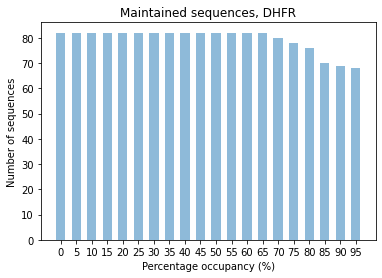

In [15]:
%matplotlib inline
y_pos = range(0,100,5)
fig, ax = plt.subplots()
plt.bar(y_pos, checks, alpha = 0.5, width = 3, align = 'center')
plt.xticks(y_pos)
plt.ylabel('Number of sequences')
plt.xlabel('Percentage occupancy (%)')
plt.title('Maintained sequences, DHFR')

In [16]:
# Write a function to save the refined alignments
def write_prody_aln(ref_alignment, outfile):
    '''This function receives a refined alignment variable (ProDy's MSA class) and a path to an output file.
    It will save the alignment in the fasta format.
    '''
    # Start the output variable
    records = []
    id_list = ref_alignment.getLabels()
    # Loop through each of the records
    for i in range(len(id_list)):
        new_id = id_list[i]
        full_sequence = ''
        seq_array = ref_alignment.getArray()[i]
        for j in range(len(seq_array)):
            full_sequence = full_sequence + seq_array[j].decode('UTF-8')
        new_record = SeqRecord(Seq(full_sequence), id = new_id)
        records.append(new_record)
    # Write the sequences
    SeqIO.write(records, outfile, 'fasta')

In [19]:
# Save the refined alignment
write_prody_aln(msa_dhfr_refined, '../../Data/Evolutionary_analysis/DataS1_DfrB1_DMS_2022.fasta')

In [21]:
# Calculate Shannon entropy for each position
entropy = calcShannonEntropy(msa_dhfr_refined)
np.savetxt(os.path.join('../../Data/Evolutionary_analysis/', 'DHFR_entropy.txt'), entropy)

<BarContainer object of 78 artists>

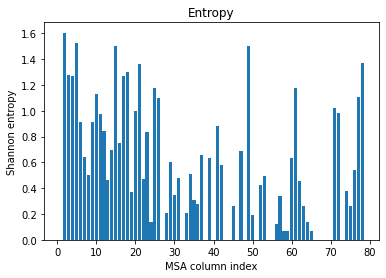

In [22]:
# Show the figure for Shannon entropy
showShannonEntropy(entropy)

Text(0.5, 0, 'Position')

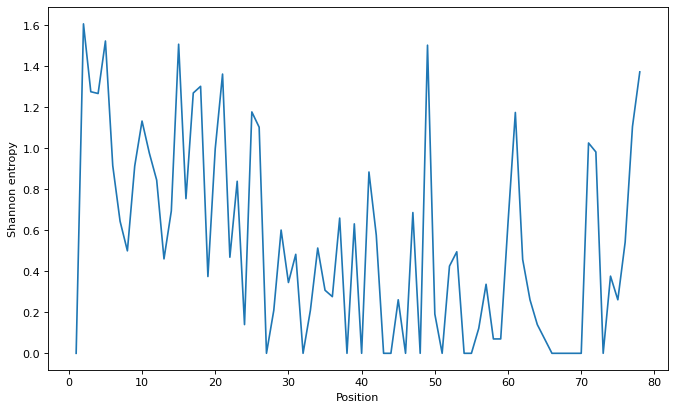

In [27]:
positions = range(1, 79)
figure(figsize=(10, 6), dpi=80)
plot(positions, entropy)
plt.ylabel('Shannon entropy')
plt.xlabel('Position')